In [1]:
pip install nibabel

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install itkwidgets

In [3]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn 

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import nibabel as nib                                                     
import itk                                                                
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate

%matplotlib inline
import seaborn as sns

In [6]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [7]:
import tarfile
import os
import shutil
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

2023-10-30 10:19:40.390219: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 10:19:40.438530: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
import tarfile
file = tarfile.open('BraTS2021_Training_Data.tar')

file.extractall('BraTS2021_Training_Data')
file.close()

In [10]:
data_dir = 'BraTS2021_Training_Data'
patient_folders = [f.path[-15:] for f in os.scandir(data_dir) if f.is_dir()]
len(patient_folders)

1251

In [11]:
image_path = "./brain_images/BraTS2021_00284/BraTS2021_00284_t1.nii.gz"
image_obj = nib.load(image_path)
type(image_obj)

nibabel.nifti1.Nifti1Image

In [12]:
image_data = image_obj.get_fdata()
print(type(image_data))
image_data.shape

<class 'numpy.ndarray'>


(240, 240, 155)

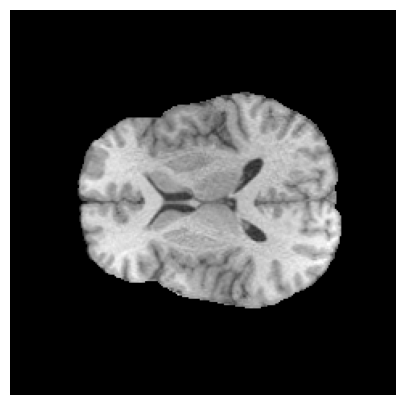

77

In [13]:
def visualize_3d(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap='gray');
    plt.axis('off')
    return layer

interact(visualize_3d, layer=(0, image_data.shape[2] - 1));


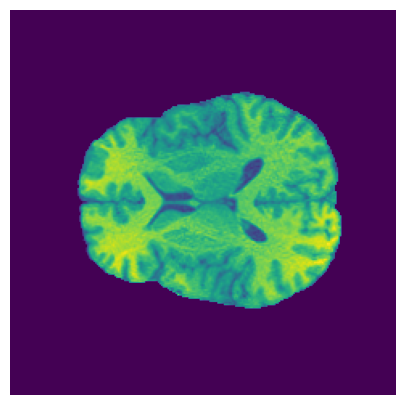

77

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def visualize_3d(layer, cmap_name='viridis'):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap=cmap_name)
    plt.axis('off')
    return layer

# Specify the colormap as a parameter to the function
interact(visualize_3d, layer=(0, image_data.shape[2] - 1), cmap_name=['viridis', 'jet', 'hot', 'cool', 'rainbow']);


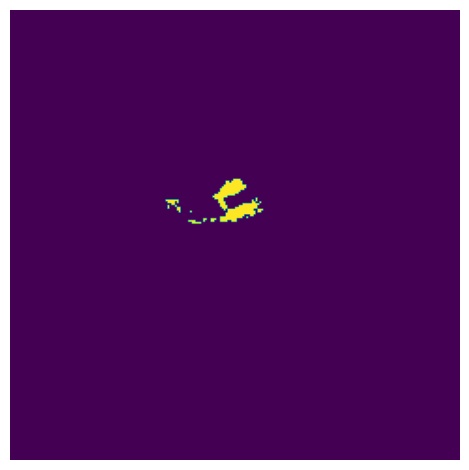

In [15]:
layer = 50
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3. 
}

def visualize_3d_labels(layer):
    mask = nib.load('./brain_images/BraTS2021_00284/BraTS2021_00284_seg.nii.gz').get_fdata()
    plt.imshow(mask[:,:,layer])
    plt.axis('off')
    plt.tight_layout()

interact(visualize_3d_labels, layer=(0, image_data.shape[2] - 1));

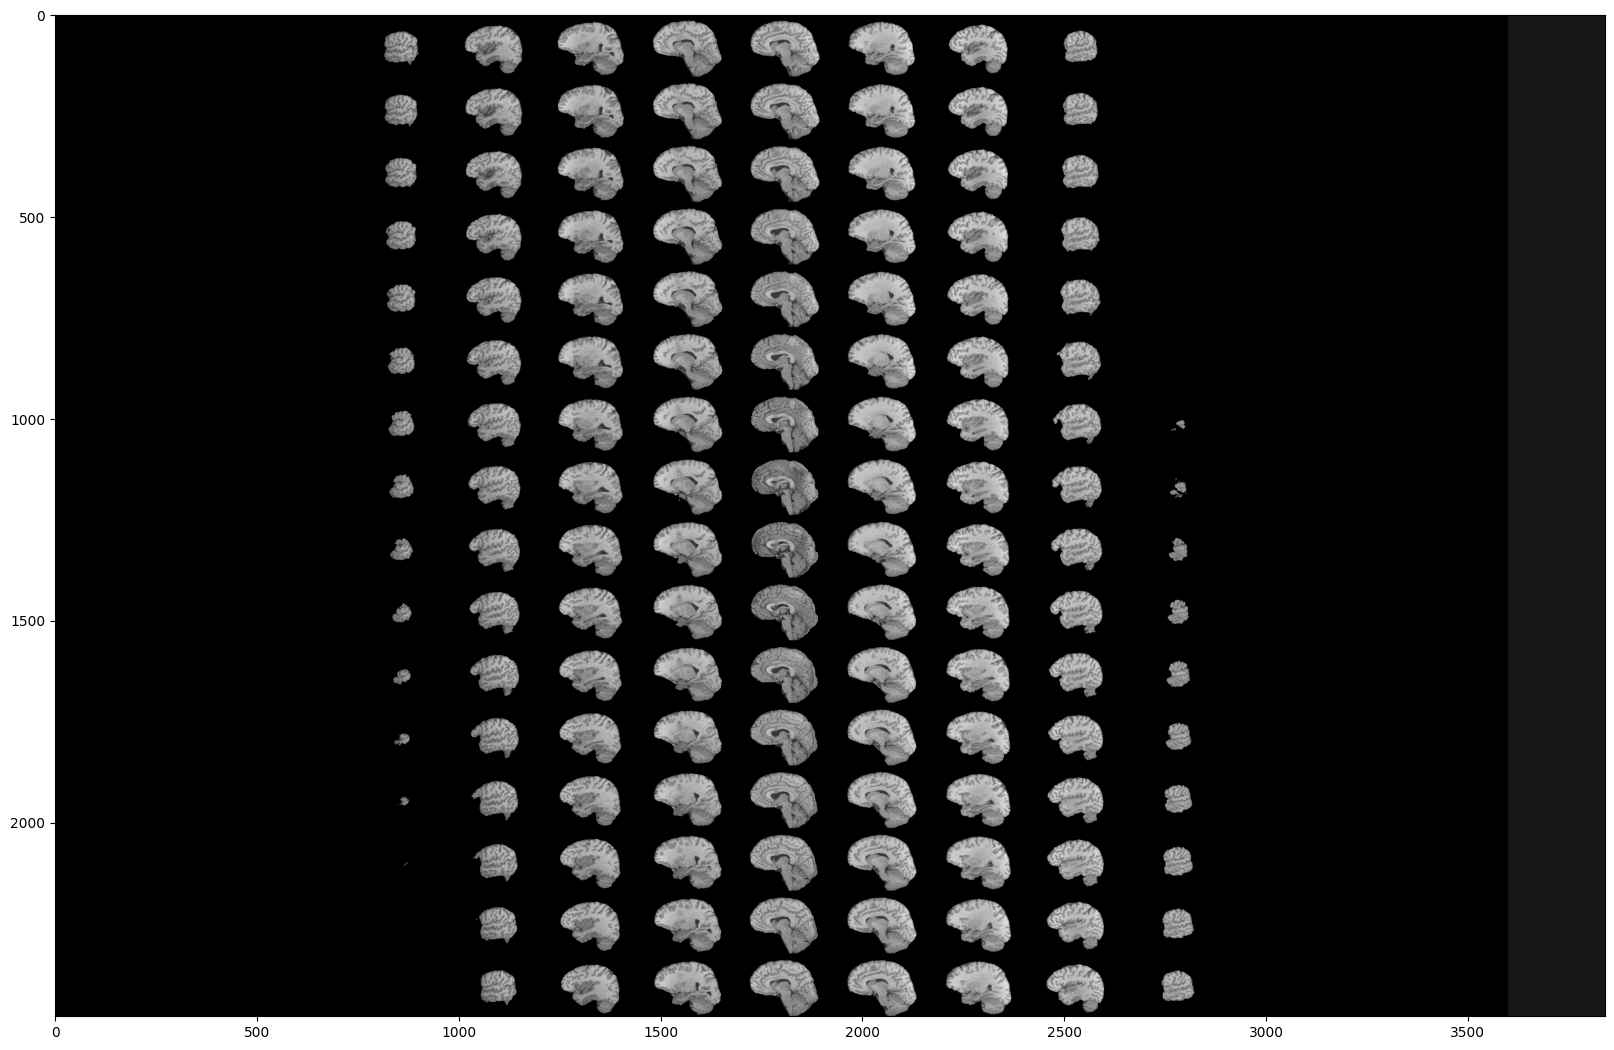

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize = (20,20))
ax1.imshow(rotate(montage(image_data[:,:,:]), 90, resize=True), cmap ='gray')

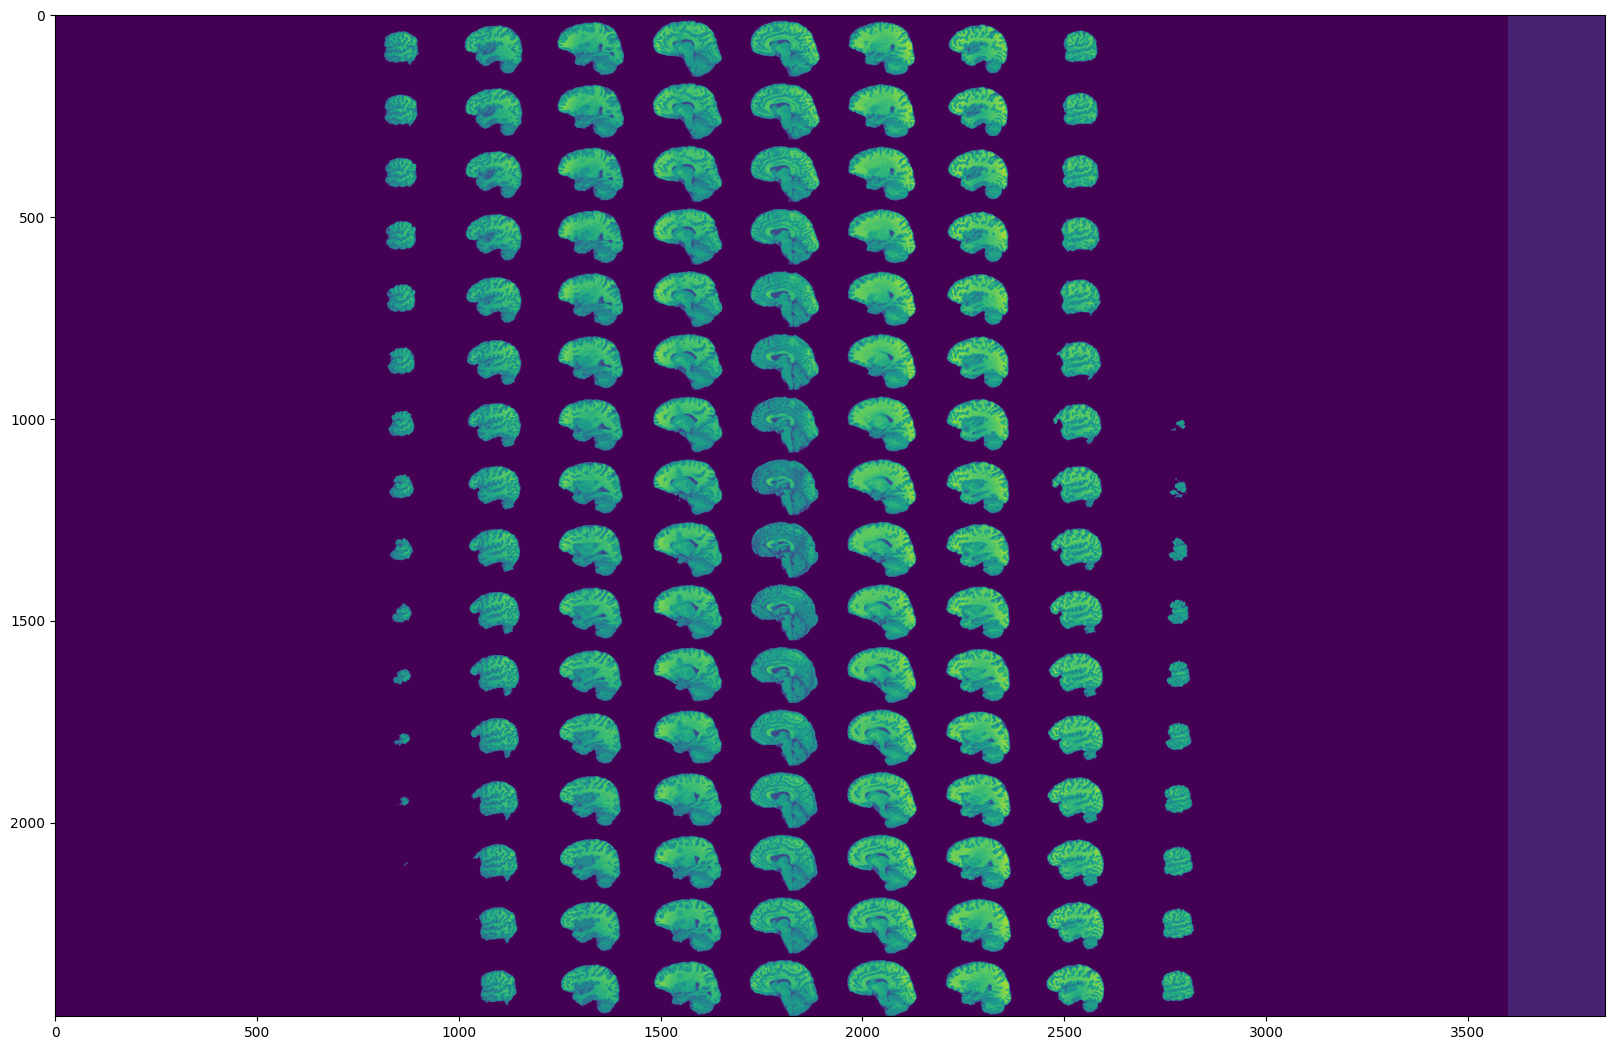

In [17]:
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import montage  # Assuming you're using skimage for montage

# Example: Using 'jet' colormap
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(rotate(montage(image_data[:, :, :]), 90, resize=True), cmap='viridis')
plt.show()


In [18]:
!pip install nibabel
import nibabel as nib

In [19]:
train_folders, temp_folders = train_test_split(patient_folders, test_size=0.2, random_state=42)
val_folders, test_folders = train_test_split(temp_folders, test_size=0.5, random_state=42)

print(len(train_folders), len(val_folders), len(test_folders))

1000 125 126


In [20]:
def data_generator(patient_folders):
    modalities = ['t1', 't1ce', 't2', 'flair']
    for patient_folder in patient_folders:
        patient_path = os.path.join(data_dir, patient_folder)
        patient_data = []

        # Load each modality and normalize
        for modality in modalities:
            modality_file = f"{patient_folder}_{modality}.nii.gz"
            img_path = os.path.join(patient_path, modality_file)
            img = nib.load(img_path).get_fdata()

            # Slice the image to 40:140 along the third dimension (z-axis)
            img = img[:, :, 40:136]

            patient_data.append(img)

        # Load the segmentation mask
        seg_file = f"{patient_folder}_seg.nii.gz"
        seg_path = os.path.join(patient_path, seg_file)
        seg = nib.load(seg_path).get_fdata()

        # Slice the segmentation mask to 40:140 along the third dimension (z-axis)
        seg = seg[:, :, 40:136]

        # Convert data to channels last format and one-hot encode the mask
        data = np.transpose(np.array(patient_data), (1, 2, 3, 0))
        label = tf.one_hot(seg.astype(np.int32), depth=4)

        yield data, label

# Create TensorFlow datasets with a lower shuffle buffer size
# Update the buffer size to a smaller value (e.g., 100)
buffer_size = 100

train_dataset_tf = tf.data.Dataset.from_generator(lambda: data_generator(train_folders),
                                                 output_signature=(tf.TensorSpec(shape=(240, 240, 96, 4), dtype=tf.float32),
                                                                   tf.TensorSpec(shape=(240, 240, 96, 4), dtype=tf.float32)))

val_dataset_tf = tf.data.Dataset.from_generator(lambda: data_generator(val_folders),
                                               output_signature=(tf.TensorSpec(shape=(240, 240, 96, 4), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(240, 240, 96, 4), dtype=tf.float32)))

test_dataset_tf = tf.data.Dataset.from_generator(lambda: data_generator(test_folders),
                                                output_signature=(tf.TensorSpec(shape=(240, 240, 96, 4), dtype=tf.float32),
                                                                  tf.TensorSpec(shape=(240, 240, 96, 4), dtype=tf.float32)))

# Batch and shuffle with the reduced buffer size
batch_size = 32

# Reduce the shuffle buffer size by setting the 'buffer_size' parameter
train_dataset_tf = train_dataset_tf.shuffle(buffer_size).batch(batch_size)
val_dataset_tf = val_dataset_tf.batch(batch_size)
test_dataset_tf = test_dataset_tf.batch(batch_size)


2023-10-30 10:20:16.855543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47311 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:18:00.0, compute capability: 7.5


In [21]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf

    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)


# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [22]:
IMG_SIZE=128

In [23]:
TRAIN_DATASET_PATH = './brain_images'

file = tarfile.open('BraTS2021_Training_Data.tar')
file.extractall('./val_brain_images')
file.close()

In [24]:
VALIDATION_DATASET_PATH = '../val_brain_images'

In [25]:
import os
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

In [26]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [27]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 128 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [28]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
             X[j+(VOLUME_SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
             
             
             y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        X = X.reshape(1,128,128,128,2)
        y = y.reshape(1,128,128,128)
        # Generate masks
        y[y==4] = 3;
        y = tf.one_hot(y, 4);
        #Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        #Y = np.array(Y).reshape(1,128,128,128)
        return X/np.max(X), y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [29]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),
      csv_logger
    ]

In [30]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
    
  X = add([input_mat,X]);
  
  return X


def Vnet_3d(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

  #c1 = conv_block(input_img,n_filters,3,batch_norm)
  c1 = Conv3D(n_filters,kernel_size = (5,5,5) , strides = (1,1,1) , padding='same')(input_img)
  #c1 = add([c1,input_img])
  
  c2 = Conv3D(n_filters*2,kernel_size = (2,2,2) , strides = (2,2,2) , padding = 'same' )(c1)
  
  c3 = conv_block(c2 , n_filters*2,5,True)
  
  p3 = Conv3D(n_filters*4,kernel_size = (2,2,2) , strides = (2,2,2), padding = 'same')(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv_block(p3, n_filters*4,5,True)
  p4 = Conv3D(n_filters*8,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c4)
  p4 = Dropout(dropout)(p4)
    
  c5 = conv_block(p4, n_filters*8,5,True)
  p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c5)
  p6 = Dropout(dropout)(p6)
  #c6 = conv_block(p5, n_filters*8,5,True)
  #p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c6)

  p7 = conv_block(p6,n_filters*16,5,True)
    
  u6 = Conv3DTranspose(n_filters*8, (2,2,2), strides=(2, 2, 2), padding='same')(p7);
  u6 = concatenate([u6,c5]);
  c7 = conv_block(u6,n_filters*16,5,True)
  c7 = Dropout(dropout)(c7)
  u7 = Conv3DTranspose(n_filters*4,(2,2,2),strides = (2,2,2) , padding= 'same')(c7);

  
  u8 = concatenate([u7,c4]);
  c8 = conv_block(u8,n_filters*8,5,True)
  c8 = Dropout(dropout)(c8)
  u9 = Conv3DTranspose(n_filters*2,(2,2,2),strides = (2,2,2) , padding= 'same')(c8);
    
  u9 = concatenate([u9,c3]);
  c9 = conv_block(u9,n_filters*4,5,True)
  c9 = Dropout(dropout)(c9)
  u10 = Conv3DTranspose(n_filters,(2,2,2),strides = (2,2,2) , padding= 'same')(c9);
  
  
  u10 = concatenate([u10,c1]);
  c10 = Conv3D(n_filters*2,kernel_size = (5,5,5),strides = (1,1,1) , padding = 'same')(u10);
  c10 = Dropout(dropout)(c10)
  c10 = add([c10,u10]);
  
  

  #c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv3D(4, (1,1,1), activation='softmax')(c10)

  model = Model(inputs=input_img, outputs=outputs)

  return model

In [31]:
input_layer = Input((128,IMG_SIZE, IMG_SIZE, 2))

model1 = Vnet_3d(input_layer)
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                                dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, 
                                                                                                                dice_coef_edema ,dice_coef_enhancing] )

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 2)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 8)     2008      ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 64, 64, 64, 16)       1040      ['conv3d[0][0]']              
                                                                                                  
 conv3d_2 (Conv3D)           (None, 64, 64, 64, 16)       32016     ['conv3d_1[0][0]']            
                                                                                              

In [32]:
history =  model1.fit(training_generator,
                     epochs=10,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  
model1.save("model_vnet_2mod.h5")

Epoch 1/10


2023-10-30 10:20:53.521925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2023-10-30 10:20:55.828080: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f0364f2ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-30 10:20:55.828112: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-10-30 10:20:55.835029: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-30 10:20:55.996897: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


850/850 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9873 - mean_io_u: 0.4376 - dice_coef: 0.4630 - precision: 0.9909 - sensitivity: 0.9838 - specificity: 0.9973 - dice_coef_necrotic: 0.1738 - dice_coef_edema: 0.4029 - dice_coef_enhancing: 0.2800
Epoch 1: val_loss improved from inf to 0.12481, saving model to model_.01-0.124811.m5
850/850 [==============================] - 417s 469ms/step - loss: 0.0447 - accuracy: 0.9873 - mean_io_u: 0.4376 - dice_coef: 0.4630 - precision: 0.9909 - sensitivity: 0.9838 - specificity: 0.9973 - dice_coef_necrotic: 0.1738 - dice_coef_edema: 0.4029 - dice_coef_enhancing: 0.2800 - val_loss: 0.1248 - val_accuracy: 0.9740 - val_mean_io_u: 0.3753 - val_dice_coef: 0.3313 - val_precision: 0.9821 - val_sensitivity: 0.9714 - val_specificity: 0.9943 - val_dice_coef_necrotic: 0.0609 - val_dice_coef_edema: 0.1496 - val_dice_coef_enhancing: 0.1261 - lr: 0.0010
Epoch 2/10
850/850 [==============================] - ETA: 0s - loss: 0.0283 - acc

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


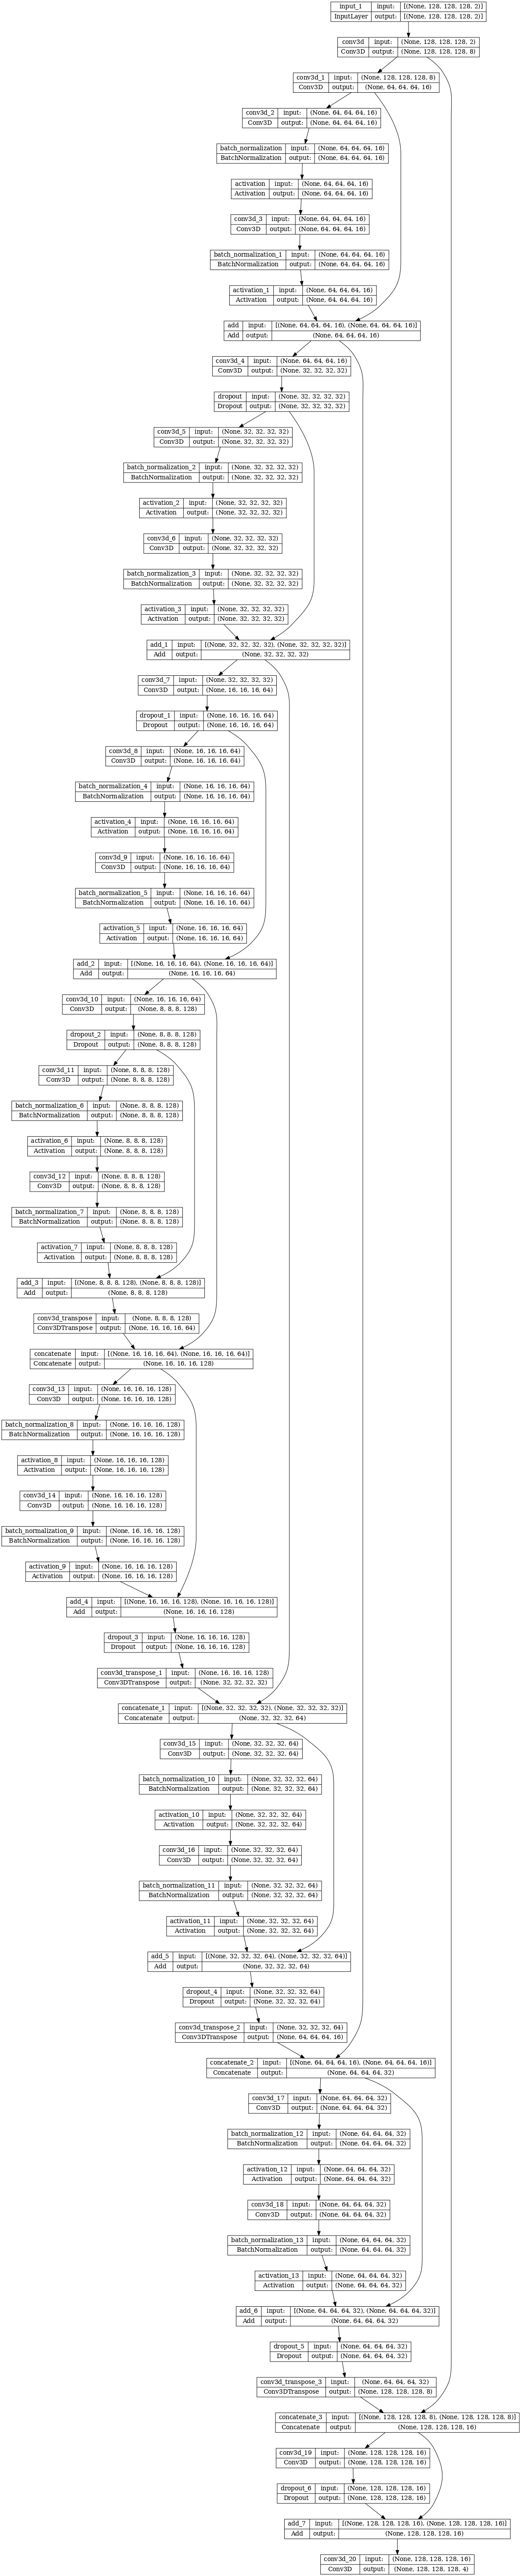

In [33]:
plot_model(model1, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [34]:
print("Evaluate on test data")
results = model1.evaluate(test_generator, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
150/150 [==============================] - 53s 350ms/step - loss: 0.2723 - accuracy: 0.9589 - mean_io_u: 0.3985 - dice_coef: 0.4457 - precision: 0.9674 - sensitivity: 0.9570 - specificity: 0.9895 - dice_coef_necrotic: 0.1856 - dice_coef_edema: 0.2813 - dice_coef_enhancing: 0.3352
test loss, test acc: [0.27228236198425293, 0.9588863253593445, 0.39851096272468567, 0.44570252299308777, 0.967421293258667, 0.9570424556732178, 0.9894734621047974, 0.1855940818786621, 0.2813415229320526, 0.3351920545101166]


In [1]:
def plot_predictions_and_ground_truth(dataset, model, num_samples=3):
    for i, (images, true_masks) in enumerate(dataset.take(num_samples)):
        pred_masks = model.predict(images)

        # Convert one-hot encoded masks back to single channel (assuming argmax along channel dimension)
        true_masks_single_channel = tf.argmax(true_masks, axis=-1)
        pred_masks_single_channel = tf.argmax(pred_masks, axis=-1)

        for j in range(true_masks.shape[0]):
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))

            # Plot original image
            ax[0].imshow(images[j, :, :, 50, 0], cmap='gray')  # Change the slice index (50 here) as needed
            ax[0].set_title('Original Image')

            # Plot ground truth mask
            ax[1].imshow(true_masks_single_channel[j, :, :, 50], cmap='gray')
            ax[1].set_title('Ground Truth Mask')

            # Plot predicted mask
            ax[2].imshow(pred_masks_single_channel[j, :, :, 50], cmap='gray')
            ax[2].set_title('Predicted Mask')

            plt.show()

# Use on your validation or test set
plot_predictions_and_ground_truth(val_dataset_tf, model)

NameError: name 'val_dataset_tf' is not defined

In [ ]:
# Assuming you already have the 'model1' loaded and trained

# Load your test data using the DataGenerator
test_generator = DataGenerator(test_ids)

# Make predictions on the test data
predictions = model1.predict(test_generator)

# 'predictions' now contains the model's predictions for the test data
# You can access the predictions for a specific sample like this:
sample_index = 0  # Replace with the index of the sample you want to get predictions for
sample_predictions = predictions[sample_index]

# 'sample_predictions' is an array with the predicted values for that sample
# It will be a 4D array with shape (128, 128, 128, 4), where 4 represents the 4 classes.

# You can access the predicted mask for a specific class (0, 1, 2, or 3) like this:
predicted_mask_class_0 = sample_predictions[:, :, :, 0]  # Replace 0 with the desired class (0, 1, 2, or 3)

# You can use these predicted masks for further analysis or visualization.
